## Single channel source separation (NMF Algorithm)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import math

from scipy.io import wavfile as wav
from scipy.signal import gaussian

In [29]:
sr, trs_wav = wav.read('./data/trs.wav')
sr, trn_wav = wav.read('./data/trn.wav')
sr, x_nmf_wav = wav.read('./data/x_nmf.wav')

In [17]:
ipd.Audio(trs_wav,rate=sr)

In [18]:
ipd.Audio(trn_wav,rate=sr)

In [30]:
ipd.Audio(x_nmf_wav,rate=sr)

In [50]:
def DFT_matrix(N):
    seq_array = np.array(range(N), ndmin=2)
    DFT = np.exp(-1j*(2*math.pi*np.dot(seq_array.T,seq_array)/N))
    return DFT

def blackman_window(frame_size):
    a_0 = 0.42
    a_1 = 0.5
    a_2 = 0.08
    return (a_0 - 
            a_1 * np.cos(2 * np.pi * np.arange(frame_size)/(frame_size-1)) + 
            a_2 * np.cos(2 * np.pi * np.arange(frame_size)/(frame_size-1)) )

def hann_window(frame_size):
    std = np.std(np.arange(frame_size))
    return scipy.signal.gaussian(M=frame_size, std=std)

def STFT(x, hop_size, frame_size, window_fun='hann'):
    
    DFT = DFT_matrix(frame_size)
    
    if window_fun == 'hann':
        window = hann_window(frame_size)
    elif window_fun == 'blackman':
        window = blackman_window(frame_size)
        
    signal_len = x.shape[0]
    zero_padding = hop_size - ((signal_len-hop_size)%hop_size)
    x = np.concatenate((x, np.zeros(hop_size)), axis=0)
    X = (x[:frame_size] * window).reshape((frame_size,1))
    start = hop_size
    
    while True:
        x_windowed = (x[start:start+frame_size] * window).reshape((frame_size, 1))
        X = np.concatenate((X, x_windowed), axis=1)
        start = int(start + hop_size)
        if signal_len < start + frame_size:
            break
    
    stft = np.dot(DFT, X)
    
    return stft

# eigen decomposition "power iteration"
def power_iteration(A):
    """
    Ideally choose a random vector to decrease the chance that our vector is orthogonal to eigen vector
    """
    b_k = np.random.rand(A.shape[0])

    for i in range(1000):
        # compute the projection of vector onto the matirx A
        b_k1 = np.dot(A,b_k)
        # normalize the projection
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1/b_k1_norm
    
    
    # rayleigh quotient in order to get the associated eigen value
    eigen_value = np.dot(b_k.T, np.dot(A, b_k))/np.dot(b_k.T,b_k)
    
    eigen_vector = np.reshape(b_k, (1, b_k.shape[0]))    
    
    # return eigen vector and eigen value
    return eigen_vector, eigen_value  

def eigen_decomposition(x):
    cov_x_eigen_values = []
    residual_cov = x
#     print(x.shape)
    for i in range(x.shape[0]):
        eigen_vector, eigen_value = power_iteration(residual_cov)
        residual_cov = residual_cov - ((eigen_value)*np.dot(eigen_vector.T, eigen_vector))
        cov_x_eigen_values.append(eigen_value)
        if i == 0:
            cov_x_eigen_vector_matrix = eigen_vector
        else:
            cov_x_eigen_vector_matrix = np.concatenate((cov_x_eigen_vector_matrix, eigen_vector), axis=0)
            
    return cov_x_eigen_values, cov_x_eigen_vector_matrix

def NMF_multiplicate_update(X, W, H, update=['W','H']):
        
    ones_FT = np.ones(shape=X.shape)
    for i in range(100):
        if 'W' in update and 'H' in update:
            W = W * (np.dot((X/np.dot(W,H)), H.T)/np.dot(ones_FT,H.T))
            H = H * (np.dot(W.T, (X/np.dot(W,H)))/np.dot(W.T,ones_FT))
        elif 'H' in update:
            H = H * (np.dot(W.T, (X/np.dot(W,H)))/np.dot(W.T,ones_FT))
            
    if 'W' in update and 'H' in update:
        return W, H
    elif 'H' in update:
        return H

In [61]:
frame_size = 1024
stft_S = STFT(x=trs_wav, hop_size=512,frame_size=frame_size, window_fun='hann')
stft_N = STFT(x=trs_wav, hop_size=512,frame_size=frame_size, window_fun='hann')
S = np.absolute(stft_S[:513])
N = np.absolute(stft_N[:513])

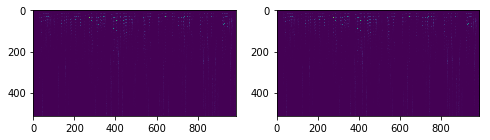

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1); plt.imshow(S)
plt.subplot(2,2,2); plt.imshow(N)
plt.show()

In [53]:
number_of_basis_vectors = 30
W = np.random.uniform(size=(X.shape[0],number_of_basis_vectors))
H = np.random.uniform(size=(number_of_basis_vectors,X.shape[1]))
W_S, H_S = NMF_multiplicate_update(X=S, W=W, H=H)
W_N, H_N = NMF_multiplicate_update(X=N, W=W, H=H)

### Denoising a noisy speech signal

In [55]:
stft_X_nmf = STFT(x=x_nmf_wav, hop_size=512,frame_size=1024, window_fun='hann')
X_nmf = np.absolute(stft_X_nmf[:513])
W_xnmf = np.concatenate((W_S,W_N), axis=1)
H_xnmf = np.random.uniform(size=(W_xnmf.shape[1],X_nmf.shape[1]))
H_xnmf = NMF_multiplicate_update(X=X_nmf, W=W_xnmf, H=H_xnmf, update=['H'])

### Mixing matrix

In [56]:
M_bar = np.dot(W_S, H_xnmf[:30])/np.dot(np.concatenate((W_S, W_N), axis=1),H_xnmf)

### singal recovery from noised signal in STFT

In [59]:
X_nmf_recovered = M_bar * stft_X_nmf[:513]

### Time domain recovery (inverse fourier transform)

In [64]:
x_nmf_wav_recovered = (1/frame_size)*np.dot(np.concatenate(X_nmf_recovered, np.conjugate(X_nmf_recovered), axis=1).T, 
                                            DFT_matrix(frame_size)).real

TypeError: concatenate() takes at most 2 arguments (3 given)

In [69]:
np.concatenate((X_nmf_recovered, np.conjugate(X_nmf_recovered[])), axis=0).shape

(1026, 129)

In [ ]:
piano_wav_recovered = (1/point_frames)*np.dot(S.T, 
                                                  np.exp(-1j*(2*math.pi*np.dot(
                                                      seq_array[:,:513].T,seq_array[:,:513])/point_frames))).real
piano_wav_reconstructed = np.zeros(int(piano_wav_recovered.shape[0]*piano_wav_recovered.shape[1]))